# Demo Notebook for processing your own indoor video with NavImpaired

### You need to specify path of the model checkpoint and the video you want to process.

In [1]:
path = 'video_processing/9000_0.97_20_50_150_0.001_128_hard_5_4_dueling_testing.pt'
video_path = 'video_processing/video.mp4'
output_path = 'video_processing/final_video.avi'


### Imports and loading segformer. The first time you import the model from huggingface, it will download it automatically.

In [2]:
import cv2
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from PIL import Image
import requests
import torch
import torch.nn.functional as F
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import io
import os
from torch.utils.data import Dataset, DataLoader



os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" #to fix an issue due to multiple OpenMP runtime
size = 4 #Segformer scale (up to 4, better performances but will require more memory and time)

print('Loading model')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Assuming you have a processor that can convert logits to predictions
# (e.g., converting logits to segmentation mask using argmax)
processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b"+str(size)+"-finetuned-ade-512-512")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b"+str(size)+"-finetuned-ade-512-512").to(device)



C:\Users\ilias\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


Loading model


C:\Users\ilias\anaconda3\Lib\site-packages\transformers\models\segformer\image_processing_segformer.py:100: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


## Extracting frames from the video (takes some time)

In [3]:
vidcap = cv2.VideoCapture(video_path)
success,image = vidcap.read()
count = 0
success = True

print('Transforming Video into frames')
frames = []
while success:
    success,image = vidcap.read()
    if success:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        min_shape = np.array(image.shape[:2]).min()
        if min_shape>1024: #this with lower memory usage
            image = np.array(Image.fromarray(image).resize((int(image.shape[1]//2),int(image.shape[0]//2))))
        frames.append(image)
    if cv2.waitKey(10) == 27:                     # exit if Escape is hit
        break
    count += 1
    
length = len(frames)//10 * 10
frames = frames[:length]

Transforming Video into frames


## Set the Ade20k labels you want to be considered as obstacles : full list here (https://huggingface.co/datasets/huggingface/label-files/blob/main/ade20k-id2label.json)

In [4]:
OI = {
  #"0": "wall",
  #"3": "floor",
  "8": "windowpane",
  "15": "table",
  "19": "chair",
  "23": "sofa",
  "24": "shelf",
  "30": "armchair",
  "31": "seat",
  "33": "desk",
  "38": "railing",
  "42": "column",
  "53": "stairs",
  "64": "coffee table",
  "69": "bench",
  "75": "swivel chair",
  "77": "bar",
  "95": "bannister",
  "110": "stool",
  "111": "barrel",
  "115": "bag",
  "121": "step",
  "130": "screen",
  "132": "sculpture",
  "147": "glass",
}
oii = torch.tensor([int(i) for i in list(OI.keys())])


### Utils and NavImpaired import

In [5]:


def visualize_arrows(frame, probabilities):
    height, width, _ = frame.shape
    frame = frame.copy()

    # Arrow length proportional to the image size
    arrow_length = min(height, width) // 4

    # Arrow colors (assuming probabilities are in the range [0, 1])
    arrow_colors = [(255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 0)]

    # Convert angles to radians
    angles = [np.radians(angle) for angle in [90, 0, 180, -90]]

    for angle, prob,k in zip(angles, probabilities,range(len(probabilities))):
        # Calculate arrow tip coordinates
        color = (255,255,255)
        direction = probabilities.argmax()
        if k == direction:
            color = (0,127,0)
      

        tip_x = int(width / 4 + arrow_length * prob * np.cos(angle))
        tip_y = int(3*height / 4 - arrow_length * prob * np.sin(angle))

        # Draw arrow
        cv2.arrowedLine(frame, (width // 4, 3*height // 4), (tip_x, tip_y), color, 2)

    return frame

def visualize_arrows_bis(frame, q_value,t=3): #Plot arrows for A theta
    height, width, _ = frame.shape
    frame = frame.copy()
    if q_value < t:
        color = (255,0,0)
    else:
        color = (0,255,0)
    q_value = min(q_value,6)
    q_value/=10
    arrow_length = min(height, width) // 4


    angle = np.radians(90)



    tip_x = int(width / 4 + arrow_length * q_value * np.cos(angle))
    tip_y = int(height / 4 - arrow_length * q_value * np.sin(angle))

    cv2.arrowedLine(frame, (width // 4, height // 4), (tip_x, tip_y), color, 2)

    return frame



class MNmodelPartAM_Dueling(nn.Module):
    def __init__(self,scale,output = 128,dropout=0.25,n_actions=5,am=10,aes=10,ahes=100,n_frames=3): #action memory, action embed size, action historic embed size
        super(MNmodelPartAM_Dueling, self).__init__()
        self.unet = False
        self.y_size = 10*am
        self.n_actions = n_actions
        self.am = am
        self.dropout = dropout
        self.output = output
        self.conv0 = nn.Conv2d(n_frames, 16*scale, kernel_size=5, stride=1,padding=1) #CHECK HOW SPATIAL DIM IS REDUCED AFTER THIS
        self.conv1 = nn.Conv2d(16*scale, 16*scale, kernel_size=3, stride=2,padding=1) #CHECK HOW SPATIAL DIM IS REDUCED AFTER THIS
        self.conv2 = nn.Conv2d(16*scale, 16*scale, kernel_size=3, stride=2,padding=1)
        self.conv3 = nn.Conv2d(16*scale, 4*scale, kernel_size=3, stride=1,padding=1)
        self.conv4 = nn.Conv2d(4*scale, 1*scale, kernel_size=3, stride=2,padding=1)

        self.fc1 = nn.Linear(1*scale*16*16, 1*scale*16*16)
        self.dropout1 = nn.Dropout(self.dropout)
        self.fc2 = nn.Linear(1*scale*16*16, scale*8*16)
        self.dropout2 = nn.Dropout(self.dropout)
        self.fc3 = nn.Linear(scale*8*16, 16*16)
        self.dropout3 = nn.Dropout(self.dropout)
        self.fc4 = nn.Linear(16*16+ahes, 16*16+ahes) 
        self.dropout4 = nn.Dropout(self.dropout)

        self.fcv1 = nn.Linear(16*16+ahes, 16*16+ahes)
        self.fcv2 = nn.Linear(16*16+ahes, 100)
        self.fcv3 = nn.Linear(100, 1)
        
        self.fc5 = nn.Linear(16*16+ahes, 16*16+ahes)
        self.dropout5 = nn.Dropout(self.dropout)
        self.fc6 = nn.Linear(16*16+ahes, self.output)
        
        self.fc1_y = nn.Linear(self.n_actions, aes)
        self.fc2_y = nn.Linear(aes*am, ahes)
        self.dropout6 = nn.Dropout(self.dropout)
        self.dropout7 = nn.Dropout(self.dropout)
        
        self.initialize_weights()
    def initialize_weights(self):
        for param in self.parameters():
            if param.requires_grad:
                if len(param.shape) > 1:
                    init.xavier_uniform_(param)
                else:
                    init.constant_(param, 0)
    def forward(self, x, y, eval = False):
        x = F.gelu(self.conv0(x))
        x = F.gelu(self.conv1(x))
        x = F.gelu(self.conv2(x))
        x = F.gelu(self.conv3(x))
        x = F.gelu(self.conv4(x))
        x = x.flatten(1)
        

        x = F.gelu(self.fc1(x))
        if not eval:
            x = self.dropout1(x)
        x = F.gelu(self.fc2(x))
        if not eval:
            x = self.dropout2(x)
        x = F.gelu(self.fc3(x))
        if not eval:
            x = self.dropout3(x)


        y = F.gelu(self.fc1_y(y)) #action_mapping
        if not eval:
            y = self.dropout6(y)
        y = y.flatten(-2) #concatenate action embeds
        y = F.gelu(self.fc2_y(y))
        if not eval:
            y = self.dropout7(y)

        x = torch.cat((x,y),axis=-1)
        
        x = F.gelu(self.fc4(x))
        v = F.gelu(self.fcv3(F.gelu(self.fcv2(F.gelu(self.fcv1(x))))))
        
        x = F.gelu(self.fc5(x))
        a = F.gelu(self.fc6(x))
        norm_cst = a.mean()
        
        return 1,v+a-norm_cst



class FramesDataset(Dataset):
    def __init__(self, frames_list, inet_mean = torch.tensor([0.485,0.456,0.406]), inet_std = torch.tensor([0.229,0.224,0.225])):

        self.frames_list = frames_list
        self.inet_mean = inet_mean
        self.inet_std = inet_std
    def preprocess_frame(self,frame):
        return(((torch.tensor(np.array(Image.fromarray(frame).resize((512,512))))/255-self.inet_mean)/self.inet_std).permute((2,0,1)))
    def __len__(self):
        return len(self.frames_list)

    def __getitem__(self, idx):
        frame = self.frames_list[idx]
        processed_frame = self.preprocess_frame(frame)
        return processed_frame

    
    
model_RL = MNmodelPartAM_Dueling(scale=3,output=4,dropout=0,n_actions = 4,am = 20,aes = 20, ahes = 150,n_frames = 3)
model_RL.load_state_dict(torch.load(path))
model_RL = model_RL.to(device)




### Launch the process (we compute segmentation and outputs only every 5 frames to save time)

In [6]:
steps = 5
t_floor = 0.3
t_wall = 0.05
t_obstacles = 0.3
t_ceiling = 0.3
v_thetas = []
frames_seg = []
probas_moves = []


DT = FramesDataset(frames[::steps])
dataloader = DataLoader(DT, batch_size=2, shuffle=False)

print('Computing segmentation maps and q values')
for batch in tqdm(dataloader):
    # Process your batch here
    with torch.no_grad():
        logits = model(**{'pixel_values':batch.to(device)}).logits.transpose(1,3).transpose(1,2)
    probas = F.softmax(logits,dim=-1)

    floor = (probas[:,:,:,3]>t_floor)*1
    wall = (probas[:,:,:,0]>t_floor)*1
    
    ceiling = (probas[:,:,:,5]>t_ceiling)*1
    
    obstacles = (probas[:,:,:,oii].max(axis=-1).values>t_obstacles)*1

    
    id_floor = torch.where(floor)
    id_ceiling = torch.where(ceiling)
    id_wall = torch.where(wall)
    id_obstacles = torch.where(obstacles)

    tmp = torch.zeros_like(floor).float()-0.5 #we consider here that unsegmented pixels are walls here (improve results)
    tmp[id_ceiling] = 0
    tmp[id_floor] = 0
    tmp[id_wall] = -0.5
    tmp[id_obstacles] = -1
    

    
    frames_states = tmp.unsqueeze(1).repeat(repeats=(1,3,1,1))
    frames_seg.append((np.array((frames_states.cpu().detach().permute(0,2,3,1)+1)*127.5)).astype(np.uint8))
    action_states = torch.zeros(tmp.shape[0],20,4).to(device)
    with torch.no_grad():
        o = model_RL(frames_states,action_states)[1]
    proba_moves = np.array(nn.Softmax(-1)((o-o.mean())*5).cpu().detach())
    probas_moves.append(proba_moves)
    v_thetas.append(np.array(o.mean(-1).cpu().detach()))
    del batch
    del tmp
    del frames_states
    del action_states
    torch.cuda.empty_cache()

print('Mapping navigational features')

frames_seg = np.concatenate(frames_seg)
v_thetas = np.concatenate(v_thetas)
probas_moves = np.concatenate(probas_moves)
arrowed_segs = [visualize_arrows_bis(frames_seg[i],v_thetas[i],3) for i in tqdm(range(len(frames_seg)))] #cnvert to RGB, then draw arrows
arrowed_segs = [visualize_arrows(arrowed_segs[i],probas_moves[i]) for i in tqdm(range(len(arrowed_segs)))]
arrowed_segs = np.array(arrowed_segs).repeat(5,0)

print('Computing plots of v_theta')
q_array = v_thetas.repeat(5)
q_frames = []
for i in tqdm(range(len(q_array))):
    plt.plot(q_array[:i],c='blue')
    plt.xlim(0, len(frames))  # x-range from 0 to 2*pi
    plt.ylim(v_thetas.min()-0.2,v_thetas.max()+0.2)     
    plt.xlabel('Frame',fontsize=20)
    plt.ylabel('$V_{\\theta}$',fontsize=20)
    plt.yticks([])
    
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    image = Image.open(buf).resize((612,512))
    q_frames.append(np.array(image)[:,:,:3])
    plt.close()

print('Saving video')
frames_video = []
video = cv2.VideoWriter(output_path,cv2.VideoWriter_fourcc(*'XVID'),50, (1636,512))
for i in tqdm(range(len(frames))):
    i0 = np.array(Image.fromarray(frames[i]).resize((512,512)))
    i1 = np.array(Image.fromarray(arrowed_segs[i]).resize((512,512)))
    i2 = q_frames[i]
    image = np.concatenate((i2,i0,i1),axis=1)
    frames_video.append(image)
    video.write(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
video.release()

Computing segmentation maps and q values


100%|██████████| 97/97 [00:15<00:00,  6.41it/s]


Mapping navigational features


100%|██████████| 194/194 [00:00<00:00, 16113.41it/s]


Computing plots of v_theta


100%|██████████| 970/970 [00:53<00:00, 18.24it/s]


Saving video


100%|██████████| 970/970 [00:14<00:00, 66.34it/s]


### Full process took about 1min30 minuts on RTX 3060

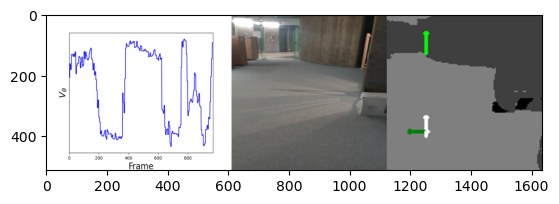

In [7]:
plt.imshow(image)

### If you want to output a gif

In [8]:
images = [Image.fromarray(i).resize((820,256)) for i in frames_video]
images = images[::3]
width, height = images[0].size


images[0].save(output_path, save_all=True, append_images=images[1:], optimize=False, duration=80, loop=0)
